# Getting to know the flexibility of ibicus: modifying and adjusting debiasers

The following notebook provides some insights into how to adjust parameters to modify debiasers. 

For in-depth information about the debiasers and their usage refer to the documentation that can be found under - API reference -> debias-module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Read in data

We start by reading in and preprocessing some data. For an explanation of the steps please refer to the "Getting started" notebook.

In [2]:
import numpy as np

def get_data(variable, data_path = "testing_data/"):
    # Load in the data 
    data = np.load(f"{data_path}{variable}.npz", allow_pickle = True)
    # Return arrays
    return data["obs"], data["cm_hist"], data["cm_future"], data["time_obs"], data["time_cm_hist"], data["time_cm_future"]

We work with daily mean near-surface temperature ('tas') and precipitation flux ('pr') in this notebook. Lets get the testing data for these two variables:

In [3]:
tas_obs, tas_cm_hist, tas_cm_future, tas_time_obs, tas_time_cm_hist, tas_time_cm_future = get_data("tas")
pr_obs, pr_cm_hist, pr_cm_future, pr_time_obs, pr_time_cm_hist, pr_time_cm_future = get_data("tas")

## 1. A first example

As shown in the 'getting started' notebook, each debiaser is a subclass of the abstract `Debiaser` class. This provides a unified interface for initialising and applying debiasers. Let's read in some temperature data:

We can initialise a debiaser for `"tas"` by using the `from_variable` method. If we want to apply ISIMIP and Equidistant-CDF-Matching (ECDFM) we can write:

In [4]:
from ibicus.debias import ECDFM, ISIMIP, DeltaChange

tas_debiaser_ECDFM = ECDFM.from_variable("tas")
tas_debiaser_ISIMIP = ISIMIP.from_variable("tas")

Applying the debiasers works using the `apply`-classmethod.

In [5]:
tas_ECDFM = tas_debiaser_ECDFM.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
  0%|                                                     | 0/225 [00:00<?, ?it/s]/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
 37%|████████████████▍                           | 84/225 [00:51<01:21,  1.73it/s]/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
 88%|█████████████████████████████████████▋     | 197/225 [01:54<00:13,  2.12it/s]/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|█████

Some debiasers like ISIMIP require additional arguments in the apply-method like the dates:

In [6]:
tas_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future =tas_time_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|███████████████████████████████████████████| 225/225 [33:11<00:00,  8.85s/it]


We can compare the bias corrected output using the evaluation framework. In this notebook, we limit ourselves to plotting the distribution of the debiased data at location [1,1]:

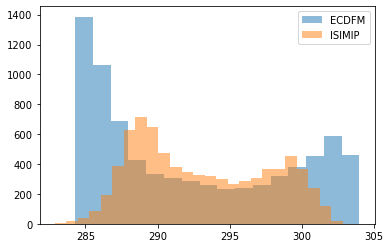

In [8]:
plt.hist(tas_ECDFM[:, 1, 1], bins="auto", alpha = 0.5, label = "ECDFM")
plt.hist(tas_ISIMIP[:, 1, 1], bins="auto", alpha = 0.5, label = "ISIMIP")
plt.legend()
plt.show()

We see that the data distributions produced by ECDFM and ISIMIP do differ. For info on how to evaluate this have a look at our notebook on evaluation

## 2. Going deeper: initialising and applying debiasers

Every debiaser that is part of the package consists of a set of parameters controlling the behavior as well as a `from_variable` and `apply`-method.

### 2.1. Initialisation

Let's have a look at the tas-ECDFM debiaser defined above using the `from_variable` method.

In [9]:
tas_debiaser_ECDFM

ECDFM(variable='Daily mean near-surface air temperature', reasonable_physical_range=[0, 400], distribution=<scipy.stats._continuous_distns.beta_gen object at 0x7f94df0a9340>)

We see that two parameters are set: a variable referring to the variable we are debiasing, as well as a distribution. These parameters fully determine the setting of this particular debiaser, equidistant-CDF-matching.

Using the `from_variable` method, a debiaser is initialized using the default parameters associated with this variable for this particular debiaser. The same outcome can be achieved by directly setting the required parameters, without using the `from_variable` method:

In [10]:
import scipy.stats
tas_debiaser_ECDFM_v2 = ECDFM(distribution=scipy.stats.beta)

And we can see that these debiasers are absolutely identical:

In [11]:
tas_debiaser_ECDFM == tas_debiaser_ECDFM_v2

True

**Learning**: if we set all the parameters needed manually to the default parameters of a specific variable, the debiaser will be equivalent to a debiaser initialized using the `from_variable` method.

Have a look at the documentation of each bias correction method to find out which parameters need to be set for that specific debiaser.

The table below gives an overview of which variables currently have default setting for which debiasers - 'experimental default settings' are marked with brackets around the x.

TODO: Insert table

If we try to initialize a debiaser that does not exist for a certain variable using the `from_variable` method, we are basically asking for error message:

In [12]:
debiaser3 = ISIMIP.from_variable("tasmin")

ValueError: Unfortunately currently no default settings exist for the variable tasmin in the debiaser ISIMIP. You can set the required class parameters manually by using the class constructor.

ISIMIP instead offers the option to debias `tasrange` and `tasskew` and calculate `tasmin` from those.

Some debiasers offer additionally a `for_precipitation` to initialise it to apply it to precipitation (`pr`). Precipitation methods can be a bit more complicated and sometimes require the specification of a threshold under which precipitation is assumed to be zero. The `for_precipitation`-method is there to facilitate the choice of method.

For example we can initialise a `QuantileMapping` debiaser with a precipitation gamma hurdle model. A hurdle model is a two step model where precipitation occurrence is modelled binomially and then a gamma distribution is assumed for the amounts. An alternative model is the censored model where all precipitation amounts under a threshold (so also all dry days) are assumed censored, so labeled 'not known' to the model.

Let's initialize both:

In [13]:
from ibicus.debias import QuantileMapping

# Initialise debiaser
pr_debiaser_QM_hurdle = QuantileMapping.for_precipitation(model_type = "hurdle")
pr_debiaser_QM_censored = QuantileMapping.for_precipitation(model_type = "censored", censoring_threshold = 0.1/86400)

### 2.2. Application

Applying the debiaser is easy with the apply-function. Lets initialise and apply a `DeltaChange` debiaser for `"tas"`:

In [15]:
tas_debiaser_DC = DeltaChange.from_variable("tas")
tas_debiased_DC = tas_debiaser_DC.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████| 225/225 [00:00<00:00, 3826.64it/s]


As you can see, the apply function needs three numpy arrays of data in the form: 

- obs representing observations of a climatological variable
- cm_hist representing climate model values for a climatological variable during a reference/the observational period
- cm_future representing climate model values for a climatological variable during a future  or application period that is to be debiased

All three are assumed to be 3d-numpy arrays where the first dimension corresponds to time and the other two to spatial locations. The locations in obs, cm_hist  and cm_future need to be the same and observational data should be interpolated to the climate model grid prior to applying the bias correction.

Besides obs, cm_hist and cm_future some debiasers might also require additional information like the dates to which observations and cm_values correspond, to for example apply the debiaser in a running window-mode. We have already seen an example in the first chapter of this notebook, when we initialized and applied ISIMIP. Dates datasets are arrays of dates in one of several formats:

In [16]:
tas_time_obs

array([cftime.DatetimeGregorian(1979, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 1, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 1, 3, 0, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2005, 12, 29, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2005, 12, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2005, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

ISIMIP also runs without having been passed date arguments, by inference:

In [17]:
tas_ISIMIP_nodates = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future)

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
  0%|                                                     | 0/225 [00:00<?, ?it/s]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
  0%|▏                                            | 1/225 [00:02<10:06,  2.71s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time inf

  7%|██▉                                         | 15/225 [00:48<13:57,  3.99s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
  7%|███▏                                        | 16/225 [00:52<13:47,  3.96s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 13%|█████▊                                      | 30/225 [01:39<10:03,  3.09s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 14%|██████                                      | 31/225 [01:43<10:21,  3.21s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 20%|████████▊                                   | 45/225 [02:24<08:32,  2.85s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 20%|████████▉                                   | 46/225 [02:27<08:32,  2.86s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 27%|███████████▋                                | 60/225 [03:11<08:26,  3.07s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 27%|███████████▉                                | 61/225 [03:14<08:22,  3.06s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 33%|██████████████▋                             | 75/225 [03:55<07:24,  2.96s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 34%|██████████████▊                             | 76/225 [03:59<07:48,  3.14s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 40%|█████████████████▌                          | 90/225 [04:43<07:16,  3.23s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 40%|█████████████████▊                          | 91/225 [04:46<07:16,  3.26s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 47%|████████████████████                       | 105/225 [05:27<05:20,  2.67s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 47%|████████████████████▎                      | 106/225 [05:29<05:17,  2.67s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 53%|██████████████████████▉                    | 120/225 [06:07<04:41,  2.68s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 54%|███████████████████████                    | 121/225 [06:10<04:40,  2.70s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 60%|█████████████████████████▊                 | 135/225 [06:47<03:55,  2.61s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 60%|█████████████████████████▉                 | 136/225 [06:49<03:53,  2.63s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 67%|████████████████████████████▋              | 150/225 [07:33<03:44,  2.99s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 67%|████████████████████████████▊              | 151/225 [07:36<03:44,  3.04s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 73%|███████████████████████████████▌           | 165/225 [08:17<02:57,  2.96s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 74%|███████████████████████████████▋           | 166/225 [08:20<02:55,  2.98s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 80%|██████████████████████████████████▍        | 180/225 [09:02<02:10,  2.90s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 80%|██████████████████████████████████▌        | 181/225 [09:05<02:09,  2.95s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 87%|█████████████████████████████████████▎     | 195/225 [09:46<01:27,  2.91s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 87%|█████████████████████████████████████▍     | 196/225 [09:48<01:22,  2.85s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

 93%|████████████████████████████████████████▏  | 210/225 [10:27<00:43,  2.93s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with time information, however the debiasing is not fundamentally changed.
                    
 94%|████████████████████████████████████████▎  | 211/225 [10:30<00:40,  2.87s/it]WARNING:root:
                    ISIMIP runs without time-information for at least one of obs, cm_hist or cm_future.
                    This information is inferred, assuming the first observation is on a January 1st. Observations are chunked according to the assumed time information. 
                    This might lead to slight numerical differences to the run with

100%|███████████████████████████████████████████| 225/225 [11:13<00:00,  2.99s/it]


It is also possible to change the verbosity with which a debiaser is run. Options include:
- 'ERRORS_ONLY' - only show error messages (as quiet as it gets)
- 'WARNINGS_AND_ERRORS' - show warnings and errors (medium quiet)
- 'INFO' - shows more info messages and runtime information (most chatty setting)

To demonstrate this, we apply the same debiaser as above but change the settings to 'ERRORS_ONLY'

In [18]:
debiaser = ISIMIP.from_variable("tas")
tas_ISIMIP_nodates = debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future, verbosity = "ERRORS_ONLY")

100%|███████████████████████████████████████████| 225/225 [10:21<00:00,  2.76s/it]


## 3. Modifying the debiasers

As seen above it is possible to initialise a debiaser either using the `from_variable`-method or the class-constructor. Using the class constructor, it is possible to extent debiasers to meteorological variables which are currently not covered by the `from_variable`-method.

However, in many cases, even when working with variables that have default settings, it will be important to modify the behavior of debiasers to improve its application for a certain variable/region and problem at hand. 

For parametric methods, we might want to change the distribution to improve fit eg. for extremes, we might want to use a different trend-capturing method if trends are unrealistic, modified or inflated, or just generally might want to do some additional adjustment the debiaser offers. 

Parameters of the debiaser can be modified either by setting them differently in the class constructor or in the `from_variable`-method. For example if we decide to apply `QuantileMapping` and the climate change trend of the model is not entirely realistic it might be a good idea not to use detrending prior to quantile mapping. This can be done as:

In [19]:
tas_debiaser_QM_v1 = QuantileMapping.from_variable("tas", detrending = "no_detrending")

or:

In [20]:
tas_debiaser_QM_v2 = QuantileMapping(distribution = scipy.stats.norm, detrending = "no_detrending")
tas_debiaser_QM_v1 == tas_debiaser_QM_v2

True

It is also possible to directly modify the class attribute: 

In [21]:
tas_debiaser_QM_v3 = QuantileMapping.from_variable("tas")
tas_debiaser_QM_v3.detrending = "no_detrending"

tas_debiaser_QM_v1 == tas_debiaser_QM_v3

True

However no validation is happening on the new arguments, so this method is generally not recommended.

We can make use of the evaluation framework to assess the goodness of fit of different distributions:

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[Text(0.5, 1.0, 'Distribution of AIC values across locations \n Daily mean near-surface air temperature')]

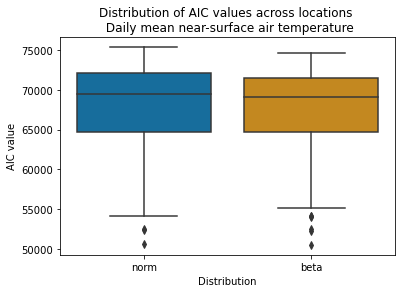

In [22]:
from ibicus.evaluate import assumptions

tas_obs_aic = assumptions.calculate_aic('tas', tas_obs, scipy.stats.norm, scipy.stats.beta)
assumptions.plot_aic(variable = 'tas', aic_values = tas_obs_aic)

We won't go into too much detail here - just to note that the functions above calculate the Akaike Information Criterion that assess the goodness of fit at each location for the different distributions. A lower AIC indicates a better fit. 

To gain some more insight into how the fits looks, we can plot the data and fit at the location with the 'worst' AIC:

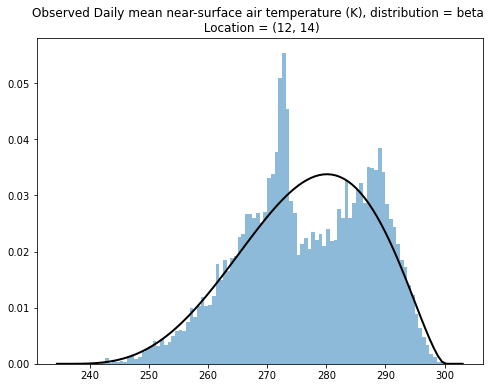

In [23]:
tas_obs_worst_fit = assumptions.plot_fit_worst_aic(variable = 'tas', dataset = tas_obs,  
                                                   data_type = 'Observed', distribution = scipy.stats.beta,
                                                   nr_bins = 100, aic_values = tas_obs_aic)

**How to know which parameters to change**: Some debiasers such as ISIMIP have many parameters to control the behavior, but oftentimes only a few are central. The documentation for each of the debiasers provides an indication of the central and required parameters and how they modify the debiasing behavior.